In [ ]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Excessive-invariance')
sys.path.append(str(base))

[autoreload of models failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [ ]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/Excessive-invariance")
os.listdir()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable, Function
from copy import deepcopy
from itertools import chain
import math
import pandas as pd
from PIL import Image

from utils import *
from models import *

In [ ]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

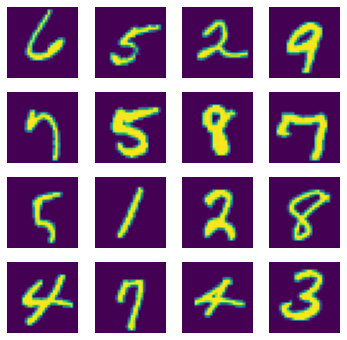

In [ ]:
fig = plt.figure(figsize=(6,6))
for i in range(16):
  index = np.random.randint(len(train_data))
  img, label = train_data[index]
  fig.add_subplot(4, 4, i+1)
#  plt.title('label: {}'.format(label))
  plt.axis('off')
  plt.imshow(torch.reshape(img, (28,28)))

###Train autoencoder

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [ ]:
autoencoder, loss_history_ae = train_autoencoder(model, criterion, optimiser, train_loader, num_epochs)

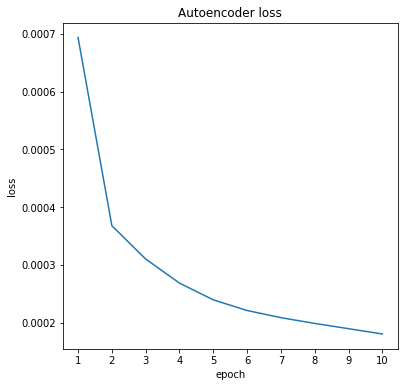

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(autoencoder.state_dict(), "pretrained_models/autoencoder.pth")


In [ ]:
# download pretrained model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('pretrained_models/autoencoder.pth'))
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in

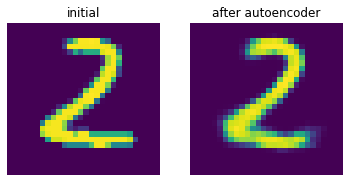

In [ ]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

###Train classifier

In [ ]:
model = Classifier().to(device)
#model = nn.Sequential(nn.Linear(10,10), nn.ReLU(), nn.Linear(10,10)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 10

In [ ]:
classifier, loss_history, acc_history = train_classifier(model, autoencoder, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(classifier.state_dict(), "pretrained_models/semantic_classifier.pth")

In [ ]:
#download pretrained model
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('pretrained_models/semantic_classifier.pth'))
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

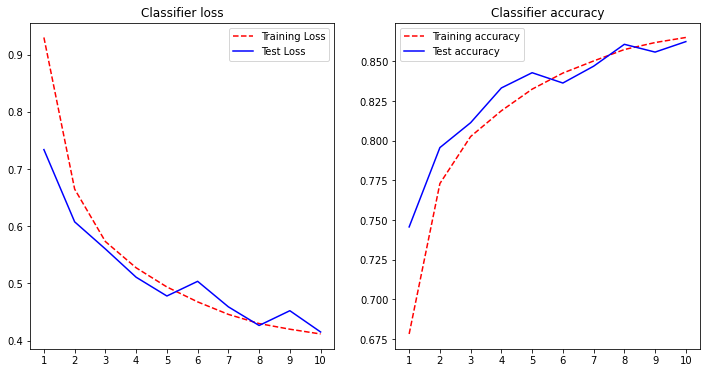

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Classifier loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Classifier accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

### Build full model with domain adaptation loss

---



In [ ]:
model = Full_model()
model.autoencoder = autoencoder

params_to_update = chain(model.semantic_classifier.parameters(),model.nuisance_classifier.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=1e-2)

num_epochs = 10

In [ ]:
full_model, acc_history, loss_history, acc_nuisance_history = train_full_model(model, optimizer, nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss(), dataloaders, num_epochs)

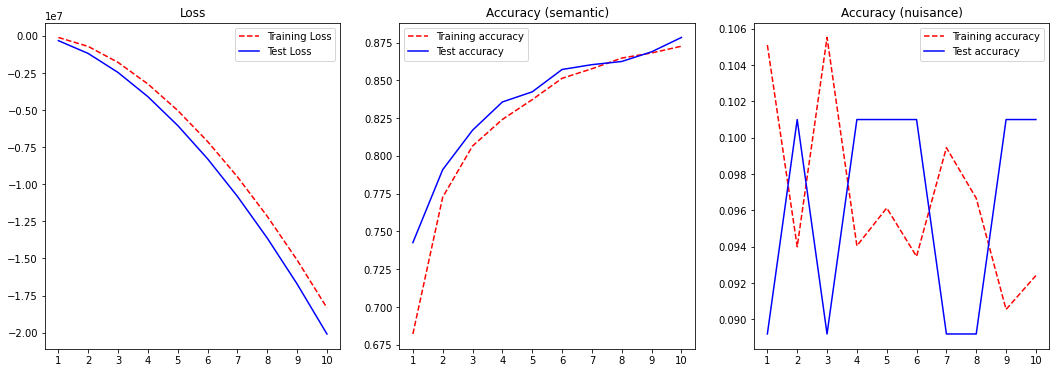

In [ ]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 3, 1)
plt.title('Loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 3, 2)
plt.title('Accuracy (semantic)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

fig.add_subplot(1, 3, 3)
plt.title('Accuracy (nuisance)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_nuisance_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_nuisance_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);


In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(full_model.state_dict(), "pretrained_models/full_model.pth")

In [ ]:
#download pretrained model
full_model = Full_model().to(device)
full_model.load_state_dict(torch.load('pretrained_models/full_model.pth'))
full_model.eval()

Full_model(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=64, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=512, out_features=1024, 

### Attack it

In [ ]:
def attack(autoencoder, classifier, full_model, input, target, num_iter, alpha, df=None):
  with torch.set_grad_enabled(True):
    input = torch.reshape(input, (1, 28*28)).to(device)
    target = torch.reshape(target, (1, 28*28)).to(device)

    first_flip = None 
    first_flip_da = None   # da = domain adaptation
    init_label = classifier.predict_by_image(input, autoencoder)
    target_label = classifier.predict_by_image(target, autoencoder)
    output_targ = autoencoder.encoder(target)[:, :10]
    best_loss = 10000.

    img = deepcopy(input)
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True).to(device)

    for i in range(num_iter):
      output = autoencoder.encoder(img)[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      #gradien descent step
      img.data -= alpha * torch.sign(img.grad.data)

      curr_label = classifier.predict_by_image(img, autoencoder)
      curr_label_da = full_model.semantic_classifier.predict_by_image(img, autoencoder)
      
      if curr_label == target_label and first_flip is None:
        first_flip = i
      if curr_label_da == target_label and first_flip_da is None:
        first_flip_da = i
      '''
      if curr_label != init_label and first_flip is None:
        first_flip = i
      if curr_label_da != init_label and first_flip_da is None:
        first_flip_da = i
      '''

  if df is not None:
      df = df.append({'input': init_label,
                      'target': target_label,
                      'flip': first_flip,
                      'flip_da': first_flip_da},
                      ignore_index=True)

  return best_img, best_loss, df

full model prediction:  4
classifier prediction:  4


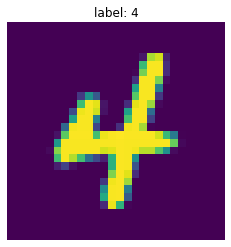

In [ ]:
index1 = np.random.randint(len(train_loader.dataset))
img1, label1 = train_loader.dataset[index1]
plt.title('label: {}'.format(label1))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

print("full model prediction: ", full_model.semantic_classifier.predict_by_image(img1, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(img1, autoencoder))

full model prediction:  8
classifier prediction:  8


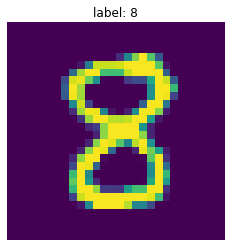

In [ ]:
index2 = np.random.randint(len(train_loader.dataset))
img2, label2 = train_loader.dataset[index2]
plt.title('label: {}'.format(label2))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

print("full model prediction: ", full_model.semantic_classifier.predict_by_image(img2, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(img2, autoencoder))

In [ ]:
df = pd.DataFrame(columns=[ 'iteration','input', 'target', 'current', 'current_da'])

full model prediction:  2
classifier prediction:  8


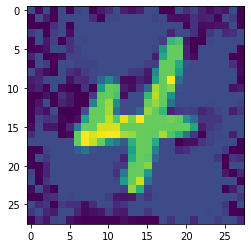

In [ ]:
adv, _, df= attack(autoencoder.encoder, classifier, full_model, img1, img2, 70, 1./255, df)

plt.imshow(torch.reshape(adv, (28, 28)).detach());
print("full model prediction: ", full_model.semantic_classifier.predict_by_image(adv, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(adv, autoencoder))

In [ ]:
df = pd.DataFrame(columns=['input', 'target', 'flip', 'flip_da'])

In [ ]:
# take a lot of data

for i in range(1000):
  index = np.random.randint(len(val_loader.dataset))
  input, _ = val_loader.dataset[index]

  index = np.random.randint(len(val_loader.dataset))
  target, _ = val_loader.dataset[index]

  _, _, df= attack(autoencoder.encoder, classifier, full_model, input, target, 100, 1./255, df)


  

In [ ]:
df.to_csv('test_domain_adaptation.csv')

###Some statistics

In [ ]:
# flip: current label = target label
df1 = pd.read_csv('results/test_domain_adaptation.csv')
df1

,Unnamed: 0,input,target,flip,flip_da
0,0,3.0,5.0,NaN,NaN
1,1,5.0,5.0,0.0,0.0
2,2,1.0,1.0,0.0,0.0
3,3,8.0,6.0,NaN,NaN
4,4,2.0,7.0,87.0,NaN
...,...,...,...,...,...
995,995,6.0,4.0,24.0,19.0
996,996,7.0,5.0,32.0,26.0
997,997,4.0,1.0,NaN,NaN
998,998,1.0,7.0,5.0,10.0


In [ ]:
tmp = df1[df1['flip'].notnull()]
correct = len(tmp[tmp['flip_da'].isna()])
tmp = tmp[tmp['flip_da'].notnull()]
correct += len(tmp[tmp['flip_da'] > tmp['flip']])
wrong = len(tmp[tmp['flip_da'] <= tmp['flip']])
print('correct: {}, wrong: {}'.format(correct, wrong))

correct: 320, wrong: 275


In [ ]:
# flip: current label != initial label
df2 = pd.read_csv('results/test_domain_adaptation2.csv')
df2

,Unnamed: 0,input,target,flip,flip_da
0,0,6.0,6.0,27.0,26.0
1,1,3.0,6.0,34.0,35.0
2,2,2.0,8.0,12.0,13.0
3,3,2.0,6.0,15.0,11.0
4,4,6.0,8.0,12.0,2.0
...,...,...,...,...,...
995,995,5.0,8.0,NaN,NaN
996,996,1.0,4.0,25.0,22.0
997,997,8.0,1.0,NaN,NaN
998,998,7.0,9.0,76.0,61.0


In [ ]:
tmp = df2[df2['flip'].notnull()]
correct = len(tmp[tmp['flip_da'].isna()])
tmp = tmp[tmp['flip_da'].notnull()]
correct += len(tmp[tmp['flip_da'] > tmp['flip']])
wrong = len(tmp[tmp['flip_da'] < tmp['flip']])
print('correct: {}, wrong: {}'.format(correct, wrong))

correct: 420, wrong: 408


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


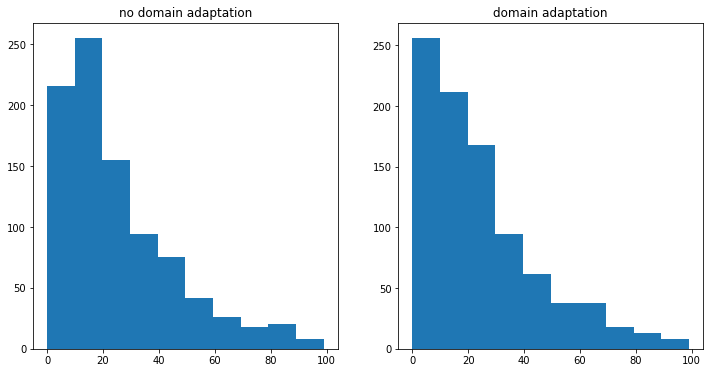

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('no domain adaptation')
plt.hist(df2['flip']);

fig.add_subplot(1, 2, 2)
plt.title('domain adaptation')
plt.hist(df2['flip_da']);fig.add_subplot(1, 2, 1)


##quasi-VAE

In [ ]:
model = quasi_VAE().to(device)
criterion = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

q_vae, loss_history_vae = train_autoencoder(model, criterion, optimiser, train_loader, num_epochs)

epoch [1/10], loss:0.0303

epoch [2/10], loss:0.0181

epoch [3/10], loss:0.0206

epoch [4/10], loss:0.0199

epoch [5/10], loss:0.0137

epoch [6/10], loss:0.0126

epoch [7/10], loss:0.0147

epoch [8/10], loss:0.0124

epoch [9/10], loss:0.0121

epoch [10/10], loss:0.0126



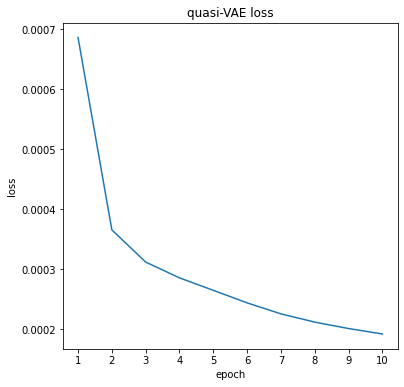

In [ ]:
plt.figure(figsize=(6,6))
plt.title('quasi-VAE loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_vae);

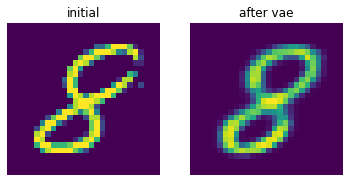

In [ ]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = q_vae(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after vae')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

In [ ]:
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
num_epochs = 10

classifier_vae, loss_history, acc_history = train_classifier(model, q_vae, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

train epoch [1/10], loss: 0.9317, acc: 0.6849
val epoch [1/10], loss: 0.7855, acc: 0.7330

train epoch [2/10], loss: 0.7403, acc: 0.7467
val epoch [2/10], loss: 0.7277, acc: 0.7531

train epoch [3/10], loss: 0.7061, acc: 0.7573
val epoch [3/10], loss: 0.7185, acc: 0.7479

train epoch [4/10], loss: 0.6872, acc: 0.7648
val epoch [4/10], loss: 0.6672, acc: 0.7696

train epoch [5/10], loss: 0.6780, acc: 0.7658
val epoch [5/10], loss: 0.6701, acc: 0.7701

train epoch [6/10], loss: 0.6683, acc: 0.7698
val epoch [6/10], loss: 0.6583, acc: 0.7713

train epoch [7/10], loss: 0.6610, acc: 0.7738
val epoch [7/10], loss: 0.6557, acc: 0.7714

train epoch [8/10], loss: 0.6559, acc: 0.7742
val epoch [8/10], loss: 0.6583, acc: 0.7711

train epoch [9/10], loss: 0.6501, acc: 0.7759
val epoch [9/10], loss: 0.6637, acc: 0.7714

train epoch [10/10], loss: 0.6481, acc: 0.7752
val epoch [10/10], loss: 0.6595, acc: 0.7709



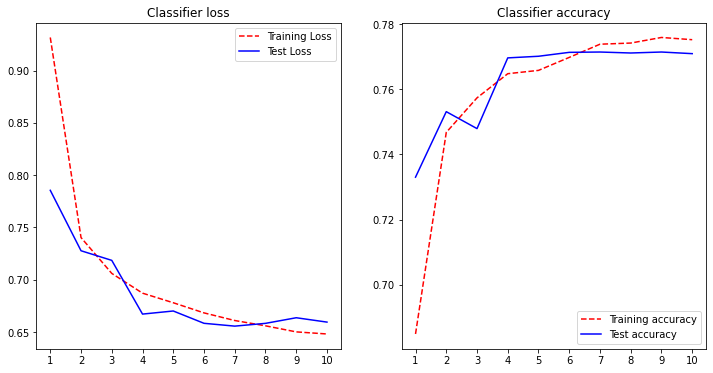

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Classifier loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Classifier accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

In [ ]:
model = Full_model()
model.autoencoder = q_vae

params_to_update = chain(model.semantic_classifier.parameters(),model.nuisance_classifier.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=1e-2)

num_epochs = 10

full_model_vae, acc_history, loss_history, acc_nuisance_history = train_full_model(model, optimizer, nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss(), dataloaders, num_epochs)

/content/drive/My Drive/Excessive-invariance/utils.py:151: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  domain_loss.data[where_nan] = 0


train epoch [1/10], class acc: 0.7053, loss: -203.4381
val epoch [1/10], class acc: 0.7519, loss: -246.4048
train epoch [2/10], class acc: 0.7504, loss: -261.2118
val epoch [2/10], class acc: 0.7589, loss: -271.6500
train epoch [3/10], class acc: 0.7601, loss: -280.8220
val epoch [3/10], class acc: 0.7635, loss: -287.4539
train epoch [4/10], class acc: 0.7643, loss: -294.7613
val epoch [4/10], class acc: 0.7650, loss: -299.9038
train epoch [5/10], class acc: 0.7664, loss: -306.4049
val epoch [5/10], class acc: 0.7574, loss: -310.7241
train epoch [6/10], class acc: 0.7659, loss: -316.8205
val epoch [6/10], class acc: 0.7545, loss: -320.6779
train epoch [7/10], class acc: 0.7658, loss: -326.5538
val epoch [7/10], class acc: 0.7713, loss: -330.1901
train epoch [8/10], class acc: 0.7651, loss: -335.8495
val epoch [8/10], class acc: 0.7741, loss: -339.2461
train epoch [9/10], class acc: 0.7672, loss: -344.7194
val epoch [9/10], class acc: 0.7720, loss: -347.9138
train epoch [10/10], class a

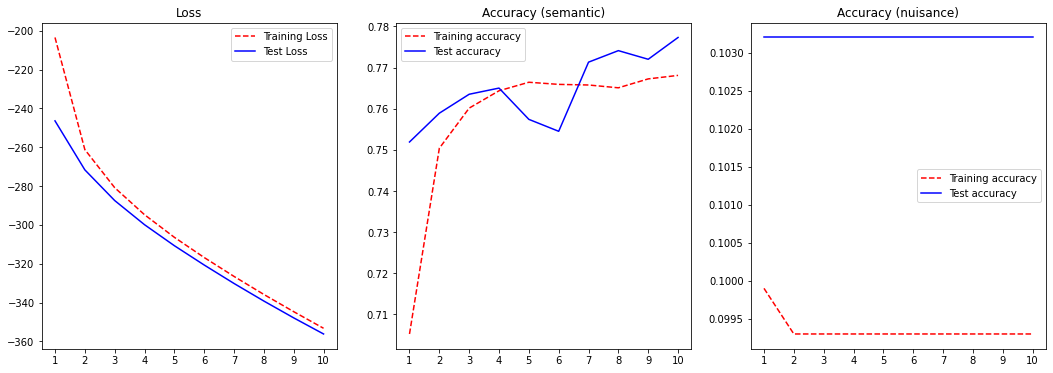

In [ ]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 3, 1)
plt.title('Loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 3, 2)
plt.title('Accuracy (semantic)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

fig.add_subplot(1, 3, 3)
plt.title('Accuracy (nuisance)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_nuisance_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_nuisance_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

In [ ]:
df = pd.DataFrame(columns=['input', 'target', 'flip', 'flip_da'])

for i in range(100):
  index = np.random.randint(len(val_loader.dataset))
  input, _ = val_loader.dataset[index]

  index = np.random.randint(len(val_loader.dataset))
  target, _ = val_loader.dataset[index]

  _, _, df= attack(q_vae, classifier_vae, full_model_vae, input, target, 200, 1./255, df)


df.to_csv('results/test_domain_adaptation_qvae.csv')

correct: 35, wrong: 43


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


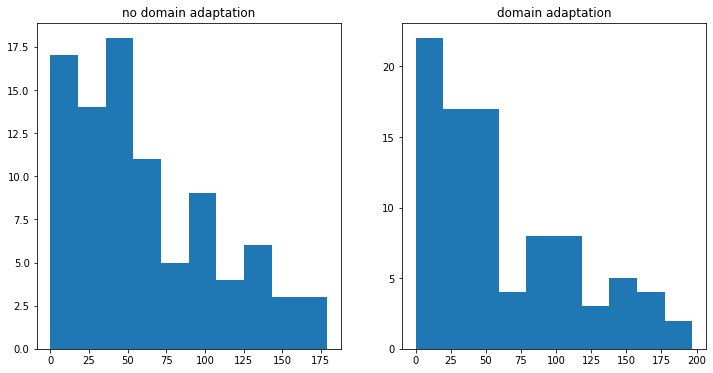

In [ ]:
tmp = df[df['flip'].notnull()]
correct = len(tmp[tmp['flip_da'].isna()])
tmp = tmp[tmp['flip_da'].notnull()]
correct += len(tmp[tmp['flip_da'] > tmp['flip']])
wrong = len(tmp[tmp['flip_da'] < tmp['flip']])
print('correct: {}, wrong: {}'.format(correct, wrong))

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('no domain adaptation')
plt.hist(df['flip']);

fig.add_subplot(1, 2, 2)
plt.title('domain adaptation')
plt.hist(df['flip_da']);

##Try VAE

In [ ]:
model = VAE().to(device)
criterion = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def loss_vae(recon_x, x, mu, logvar):
   BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
   KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
 #  print('BCE: {}, KLD: {}'.format(BCE.grad.data, KLD.grad.data))
   return BCE + 10*KLD


In [ ]:
def train_vae(model, criterion, optimizer, dataloader, num_epochs):
    
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
  model.train()
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.
  loss_history = []
  for epoch in range(num_epochs):
    running_loss = 0
    for inputs, _ in dataloader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        optimizer.zero_grad()
        outputs, mean, logvar = model(inputs)
        loss = criterion(outputs, inputs, mean, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(dataloader.dataset)
    loss_history.append(epoch_loss)
    if epoch_loss < best_loss:
        best_model_wts = deepcopy(model.state_dict())
    print('epoch [{}/{}], loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item()))

  model.load_state_dict(best_model_wts)
  return model, loss_history
  

In [ ]:
vae, loss_history_vae = train_vae(model, loss_vae, optimiser, train_loader, num_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch [1/10], loss:6500.3613

epoch [2/10], loss:6477.7070

epoch [3/10], loss:6505.0078

epoch [4/10], loss:6606.8340

epoch [5/10], loss:6267.5801

epoch [6/10], loss:6293.5449

epoch [7/10], loss:5761.3398

epoch [8/10], loss:6569.7432

epoch [9/10], loss:6181.8247

epoch [10/10], loss:6755.5415



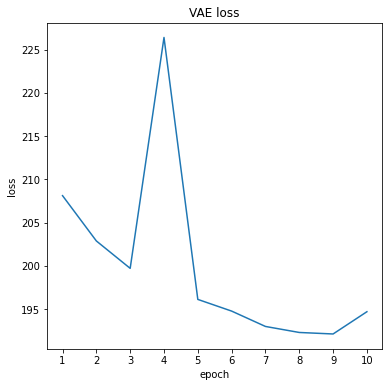

In [ ]:
plt.figure(figsize=(6,6))
plt.title('VAE loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_vae,);

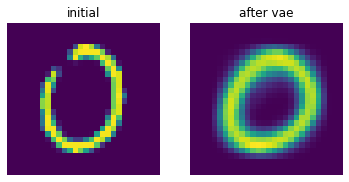

In [ ]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded, _, _ = vae(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after vae')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(vae.state_dict(), "pretrained_models/vae.pth")

In [ ]:
#download pretrained model
vae = VAE().to(device)
vae.load_state_dict(torch.load('pretrained_models/vae.pth'))
vae.eval()

VAE(
  (hidden): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (mean): Linear(in_features=64, out_features=64, bias=True)
  (logvar): Linear(in_features=64, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
 

In [ ]:
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 10

classifier_vae, loss_history, acc_history = train_classifier(model, vae, criterion, optimizer, dataloaders, dataset_sizes, num_epochs, is_vae=True)

train epoch [1/10], loss: 1.5438, acc: 0.4420
val epoch [1/10], loss: 1.3835, acc: 0.4803

train epoch [2/10], loss: 1.4010, acc: 0.4787
val epoch [2/10], loss: 1.3635, acc: 0.4937

train epoch [3/10], loss: 1.3846, acc: 0.4818
val epoch [3/10], loss: 1.3602, acc: 0.4762

train epoch [4/10], loss: 1.3693, acc: 0.4874
val epoch [4/10], loss: 1.3394, acc: 0.4919

train epoch [5/10], loss: 1.3625, acc: 0.4873
val epoch [5/10], loss: 1.3421, acc: 0.4986

train epoch [6/10], loss: 1.3614, acc: 0.4874
val epoch [6/10], loss: 1.3428, acc: 0.4950

train epoch [7/10], loss: 1.3591, acc: 0.4864
val epoch [7/10], loss: 1.3335, acc: 0.4958

train epoch [8/10], loss: 1.3568, acc: 0.4884
val epoch [8/10], loss: 1.3392, acc: 0.4972

train epoch [9/10], loss: 1.3555, acc: 0.4889
val epoch [9/10], loss: 1.3315, acc: 0.4895

train epoch [10/10], loss: 1.3519, acc: 0.4909
val epoch [10/10], loss: 1.3346, acc: 0.4920



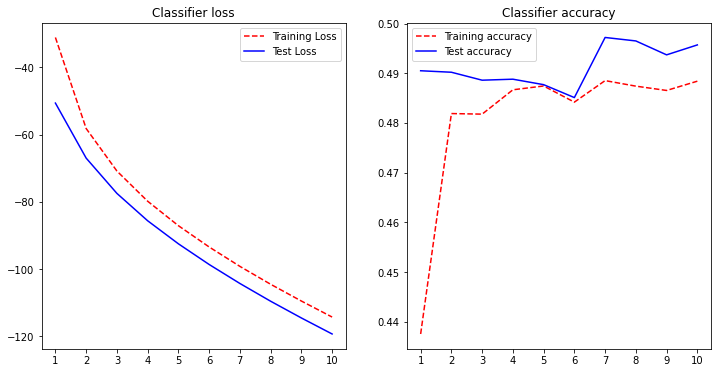

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Classifier loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Classifier accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(classifier_vae.state_dict(), "pretrained_models/classifier_vae.pth")

In [ ]:
#download pretrained model
classifier_vae = Classifier().to(device)
classifier_vae.load_state_dict(torch.load('pretrained_models/classifier_vae.pth'))
classifier_vae.eval()

In [ ]:
model = Full_model()
model.autoencoder = vae
model.is_vae = True

params_to_update = chain(model.semantic_classifier.parameters(),model.nuisance_classifier.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=1e-2)

num_epochs = 10

full_model_vae, acc_history, loss_history, acc_nuisance_history = train_full_model(model, optimizer, nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss(), dataloaders, num_epochs)

/content/drive/My Drive/Excessive-invariance/utils.py:154: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  domain_loss.data[where_nan] = 0


train epoch [1/10], class acc: 0.4375, loss: -31.0945
val epoch [1/10], class acc: 0.4905, loss: -50.6116
train epoch [2/10], class acc: 0.4819, loss: -58.1793
val epoch [2/10], class acc: 0.4902, loss: -66.9812
train epoch [3/10], class acc: 0.4818, loss: -70.8226
val epoch [3/10], class acc: 0.4886, loss: -77.4744
train epoch [4/10], class acc: 0.4867, loss: -79.8024
val epoch [4/10], class acc: 0.4888, loss: -85.6173
train epoch [5/10], class acc: 0.4874, loss: -87.0797
val epoch [5/10], class acc: 0.4877, loss: -92.4692
train epoch [6/10], class acc: 0.4842, loss: -93.4113
val epoch [6/10], class acc: 0.4851, loss: -98.6189
train epoch [7/10], class acc: 0.4885, loss: -99.1822
val epoch [7/10], class acc: 0.4972, loss: -104.2680
train epoch [8/10], class acc: 0.4874, loss: -104.5057
val epoch [8/10], class acc: 0.4965, loss: -109.5505
train epoch [9/10], class acc: 0.4865, loss: -109.4936
val epoch [9/10], class acc: 0.4937, loss: -114.5277
train epoch [10/10], class acc: 0.4884, l

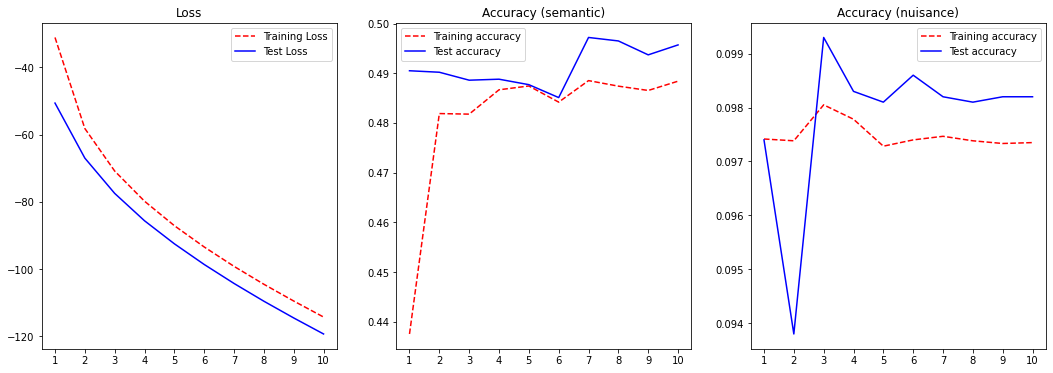

In [ ]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 3, 1)
plt.title('Loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 3, 2)
plt.title('Accuracy (semantic)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

fig.add_subplot(1, 3, 3)
plt.title('Accuracy (nuisance)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_nuisance_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_nuisance_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(full_model_vae.state_dict(), "pretrained_models/full_model_vae.pth")

In [ ]:
df = pd.DataFrame(columns=['input', 'target', 'flip', 'flip_da'])

for i in range(1000):
  index = np.random.randint(len(val_loader.dataset))
  input, _ = val_loader.dataset[index]

  index = np.random.randint(len(val_loader.dataset))
  target, _ = val_loader.dataset[index]

  _, _, df= attack(vae, classifier_vae, full_model_vae, input, target, 100, 1./255, df)


df.to_csv('results/test_domain_adaptation_vae.csv')

In [ ]:
tmp = df[df['flip'].notnull()]
correct = len(tmp[tmp['flip_da'].isna()])
tmp = tmp[tmp['flip_da'].notnull()]
correct += len(tmp[tmp['flip_da'] > tmp['flip']])
wrong = len(tmp[tmp['flip_da'] < tmp['flip']])
print('correct: {}, wrong: {}'.format(correct, wrong))

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('no domain adaptation')
plt.hist(df['flip']);

fig.add_subplot(1, 2, 2)
plt.title('domain adaptation')
plt.hist(df['flip_da']);